In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import seaborn as sns
# import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [27]:
headerss=['polarity',' id','date','query','user','review']
senti_trainn=pd.read_csv('Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv',header=None,names=headerss)
senti_test=pd.read_csv('Downloads/new_testdata.manual.2009.06.14.csv',header=None,names=headerss)
target_trianing_count=senti_trainn.polarity.value_counts()
target_test_count=senti_test.polarity.value_counts()

print(f'number of categories in trainnig set {target_trianing_count} ,and number of categories in trainnig set {target_test_count}')
#both categories are equel in both of the datasets

number of categories in trainnig set 0    800000
4    800000
Name: polarity, dtype: int64 ,and number of categories in trainnig set 4    182
0    177
Name: polarity, dtype: int64


In [4]:
#replacing the the class 4 with 1

senti_trainn['polarity']=pd.DataFrame(senti_trainn['polarity'].replace({0: 0, 4: 1}))
senti_test['polarity']= pd.DataFrame(senti_test['polarity'].replace({0: 0, 4: 1}))

target_trianing_count=senti_trainn.polarity.value_counts()
target_test_count=senti_test.polarity.value_counts()

print(f'number of categories in trainnig set {target_trianing_count} ,and number of categories in trainnig set {target_test_count}')
#both categories are equel in both of the datasets

number of categories in trainnig set 0    800000
1    800000
Name: polarity, dtype: int64 ,and number of categories in trainnig set 1    182
0    177
Name: polarity, dtype: int64


In [4]:
# #in this assignment we do not need the some fatures like date,query ,id and  user so we can drop them.
# senti_trainn=senti_trainn.drop(columns=['id', 'date', 'query', 'user'])
# senti_trainn.head()
# senti_test=senti_test.drop(columns=['id', 'date', 'query', 'user'])
# senti_test.head()
# # or we can keep them and select the requesred feaures

In [26]:

xx_train=senti_train.iloc[:,5]
yy_train=senti_train.iloc[:,0]
xx_test=senti_test.iloc[:,5]
yy_test=senti_test.iloc[:,0]
np.array(senti_trainn).shape

(1600000, 6)

In [4]:
# to see how many null value we have in trainnig set
print(senti_trainn.isnull().sum(),'number of null values')
print(senti_trainn.describe()) #to check min,max,mean, std ,etc (the basic statistics) for numeric features

#to see how many null value we have in test set
print(senti_trainn.isnull().sum(),'number of null values')
senti_trainn.describe() #to check min,max,mean, std ,etc (the basic statistics) for numeric features

polarity    0
 id         0
date        0
query       0
user        0
review      0
dtype: int64 number of null values
           polarity            id
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09
polarity    0
 id         0
date        0
query       0
user        0
review      0
dtype: int64 number of null values


,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

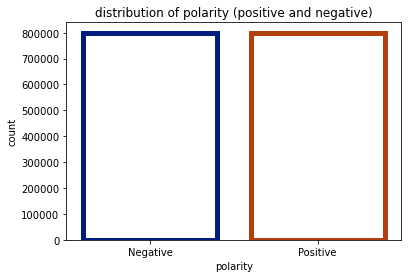

In [7]:
ax = sns.countplot(x='polarity', data=senti_trainn,
                   facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
ax.set_title("distribution of polarity (positive and negative)")
ax.set_xticklabels(['Negative', 'Positive'])

(-0.5, 399.5, 199.5, -0.5)

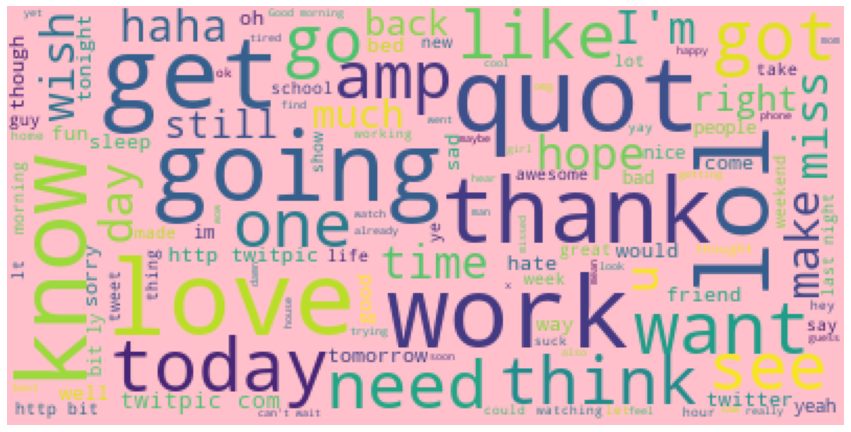

In [8]:
#plotting text

words = " ".join(words for words in senti_trainn['review'])
words_list = WordCloud(max_font_size=50, max_words=120,
                      background_color="pink", 
                      stopwords=stopwords.words("english")).generate(words)
plt.figure(figsize=(15,10))
plt.imshow(words_list)
plt.axis("off")


# Multinomial Naive Bayes

In [14]:
class MulltinomialNB:
    
    def __init__(self,alpha,y_train):
        self.alpha=alpha
        self.classes=np.unique(y_train)
        
#
    
    def clean_data(self,text):
        self.cleaned=text
        if isinstance(text, str):
#             no_html = BeautifulSoup(text).get_text()
            self.cleaned = re.sub("[^a-z\s]+", " ", text, flags=re.IGNORECASE)
#             self.cleaned=re.sub('[^a-z\s]+',' ',text,flags=re.IGNORECASE) 
            self.cleaned=re.sub('(\s+)',' ',self.cleaned) 
            self.cleaned=self.cleaned.lower() 
       
    
        return self.cleaned 


#     def _prob(self, x, mean, std):
#         exponent = np.exp(- ((x - mean)**2 / (2 * std**2)))
#         return np.log(exponent / (np.sqrt(2 * np.pi) * std))

#     def predict_log_proba(self, X):
#         return [[sum(self._prob(i, *s) for s, i in zip(summaries, x))
#                 for summaries in self.model] for x in X]

#     def predict(self, X):
#         return np.argmax(self.predict_log_proba(X), axis=1)

    # def score(self, X, y):
    #     return sum(self.predict(X) == y) / len(y)
            
    def fit(self,X,y):
        #counting number of words
        self.iinstance=X
        self.iinstance=np.array(self.iinstance)
        self.y=y
        self.y=np.array(self.y)
        
        self.Dict=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])
            
        for i,C in enumerate(self.classes):
            all_C_iinstance=self.iinstance[self.y==C]
            cleaned_iinstance=[self.clean_data(C_sample) for C_sample in all_C_iinstance]
            cleaned_iinstance=pd.DataFrame(data=cleaned_iinstance)
            np.apply_along_axis(self.Tb,1,cleaned_iinstance,i)

    def accuracy(self,x_test,y_test):
        y_pred=self.predict(x_test)
        accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]
        
        return accuracy
     
    def Tb(self,sample,dict_index):

        if type(sample)==np.ndarray:sample=sample[0]
        for t_words in sample.split(): 
            self.Dict[dict_index][t_words]+=1 
                                              
                                              
    def prob(self,x_test):  
        #computing the probalities,prior ,likelihood and etc
        
        w=[]
        Count_C=np.empty(self.classes.shape[0])
        prior=np.empty(self.classes.shape[0])
        for i,C in enumerate(self.classes):
            prior[i]=np.sum(self.y==C)/float(self.y.shape[0]) #prior
            count=list(self.Dict[i].values())
            Count_C[i]=np.sum(np.array(list(self.Dict[i].values())))+1              
            w+=self.Dict[i].keys() 
        self.len_words=np.unique(np.array(w))
        self.len_words=self.len_words.shape[0]
        
        den_val=np.array([Count_C[i]+self.len_words+1 for i,C in enumerate(self.classes)])                                                                          
        self.C_data=[(self.Dict[i],prior[i],den_val[i]) for i,C in enumerate(self.classes)]                               
        self.C_data=np.array(self.C_data)
        likelihood=np.zeros(self.classes.shape[0])
        for i,C in enumerate(self.classes):                 
            for t in x_test.split():       
              #smoothing with alpha                       
                likeliihood=(self.C_data[i][0].get(t,0))+self.alpha/float((self.C_data[i][2])+(len(self.classes)*self.alpha))                            
                likelihood[i]+=np.log(likeliihood)
                                            
        posterior=np.empty(self.classes.shape[0])
        for i,C in enumerate(self.classes):
            posterior[i]=likelihood[i]+np.log(self.C_data[i][1])                                  
      
        return posterior
    
   #final prediction
    def predict(self,x_test):
      
        pred=[] 
        for x in x_test:                                                             
            cleaned_sample=self.clean_data(x)                       
            posterior=self.prob(cleaned_sample) 
            pred.append(self.classes[np.argmax(posterior)])
                
        return np.array(pred) 

# sentiment140 dataset
### loading the dataset(the training and test data) and implementing the naive bayes 

In [35]:
senti_test=senti_test.sample(frac=.2, random_state=25)

senti_train= senti_trainn.sample(frac=.2, random_state=25)
xx_train=senti_train.iloc[:,5]
yy_train=senti_train.iloc[:,0]
xx_test=senti_test.iloc[:,5]
yy_test=senti_test.iloc[:,0]
np.array(senti_trainn).shape

(1600000, 6)

# 20newsgroups 
### loading the dataset(the training and test data) and implementing the naive bayes 

In [24]:
from sklearn.datasets import fetch_20newsgroups
categories=['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med'] 

newsgroups_train=fetch_20newsgroups(subset='train',remove=(['headers','footers','quotes']),categories=categories)

x_train=newsgroups_train.data 
y_train=newsgroups_train.target 

newsgroups_test=fetch_20newsgroups(subset='test',remove=(['headers','footers','quotes']),categories=categories) 
x_test=newsgroups_test.data 
y_test=newsgroups_test.target 

# train=x_train.sample(frac=0.2, random_state=25)
# test=x_test.sample(frac=0.2, random_state=25)


In [76]:
x=pd.DataFrame(y_test)
x

,0
0,7
1,5
2,0
3,17
4,19
...,...
7527,14
7528,4
7529,9
7530,6


Text(0.5, 1.0, 'distribution of target(20 newsgroup)')

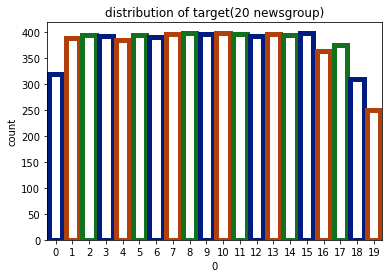

In [78]:
ax = sns.countplot(x=x[0], data=x,
                   facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
ax.set_title("distribution of target(20 newsgroup)")

In [25]:
# train_accuracy=[]
# test_accuracy=[]


nb=MulltinomialNB(1,y_train)
nb.fit(x_train,y_train)
# predic=nb.predict(x_test)
    # test_accuracyy = np.sum(predic == y_test)/predic.shape[0]
test_accuracyy=nb.accuracy(x_test,y_test)
# test_accuracy.append(test_accuracyy)
    
train_accuracyy=nb.accuracy(x_train,y_train)
# train_accuracy.append(train_accuracyy)

print (f"Test Set Accuracy for alpha : ",test_accuracyy*100,"%")
print (f"Train Set Accuracy for alpha : ",train_accuracyy*100,"%")
# print ("Accuracy for test set is : ",round(test_accuracyy*100,2),"%")
# print ("Accuracy for training set is : ",round(train_accuracyy*100,2),"%")



Test Set Accuracy for alpha :  71.83754993342211 %
Train Set Accuracy for alpha :  94.46167478954364 %


In [47]:
# plt.figure(figsize=(10,4))
# plt.bar(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
# # plt.bar(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
# plt.plot(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
# # plt.plot(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
# plt.title('train set accuracy with different alpha(20 newsgroup)')
# plt.ylabel('accuracy')
# plt.xlabel('alpha')
# plt.legend()

In [ ]:
# 20newsgroups 
### loading the dataset(the training and test data) and implementing the naive bayes 

In [44]:

test_accuracy=[]
alphaa=np.arange(0.0, 11.0, 2.0)
for i in (alphaa):

    nb=MulltinomialNB(i,yy_train)
    nb.fit(xx_train,yy_train)
    predic=nb.predict(xx_test)
#     test_accuracyy = np.sum(predic == yy_test)/predic.shape[0]
    test_accuracyy=nb.accuracy(xx_test,yy_test)
    test_accuracy.append(test_accuracyy)

    print (f"Test Set Accuracy for alpha {i}: ",test_accuracyy*100,"%")
    




<ipython-input-34-10813a4441ab>:93: RuntimeWarning: divide by zero encountered in log
  likelihood[i]+=np.log(likeliihood)


Test Set Accuracy for alpha 0.0:  62.5 %
Test Set Accuracy for alpha 2.0:  73.61111111111111 %
Test Set Accuracy for alpha 4.0:  73.61111111111111 %
Test Set Accuracy for alpha 6.0:  73.61111111111111 %
Test Set Accuracy for alpha 8.0:  73.61111111111111 %
Test Set Accuracy for alpha 10.0:  73.61111111111111 %


In [37]:



nb=MulltinomialNB(1,yy_train)
nb.fit(xx_train,yy_train)
#     predic=nb.predict(xx_test)
test_accuracyy=nb.accuracy(xx_test,yy_test)    
# train_accuracyy = np.sum(predic == yy_train)/predic.shape[0]
# train_accuracyy=nb.accuracy(xx_train,yy_train)
# train_accuracy.append(train_accuracyy)

print (f"Test Set Accuracy for alpha: ",test_accuracyy*100,"%")
# print (f"Train Set Accuracy for alpha {i}: ",train_accuracyy*100,"%")
# print ("Accuracy for test set is : ",round(test_accuracyy*100,2),"%")
# print ("Accuracy for training set is : ",round(train_accuracyy*100,2),"%")



Test Set Accuracy for alpha:  78.57142857142857 %


In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,4))
plt.bar(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
plt.bar(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
plt.plot(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
plt.plot(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
plt.title('accuracy  for train and test set with different alpha(Sentiment140 Dataset)')
plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.legend()

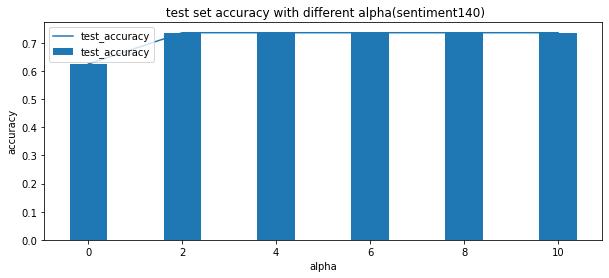

In [49]:
plt.figure(figsize=(10,5))
# plt.bar(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
plt.bar(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
# plt.plot(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
plt.plot(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
plt.title(' test set accuracy with different alpha(sentiment140)')
plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.legend()

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
# plt.bar(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
plt.plot(np.arange(0.0, 11.0, 2.0),train_accuracy,label='train_accuracy')
# plt.plot(np.arange(0.0, 11.0, 2.0),test_accuracy,label='test_accuracy')
plt.title('train set accuracy with different alpha(20 newsgroup)')
plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.legend()

# logistic repression 
### implementing the logestic Regression Model from Sikit learn for 20 newsgroups dataset

In [11]:
import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split


twentynews_x = fetch_20newsgroups(subset='all',remove=(['headers','footers','quotes']))
count_vect = CountVectorizer(analyzer ='word',lowercase=True,stop_words='english',min_df=2,max_df=0.9,max_features=50000)
X_counts=count_vect.fit_transform(twentynews_x.data)

# features_names=count_vect.get_feature_names()
#print(features_names)
tfidf_transformer = TfidfTransformer()
X= tfidf_transformer.fit_transform(X_counts)
Y=twentynews_x.target
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=4)





#implementing the logestic Regression Model from Sikit learn

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(penalty="l2",solver="saga",multi_class="multinomial",max_iter=50)
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print("Score Logestic Regressian:",score)





Score Logestic Regressian: 0.7330604820372897


# Gaussian naive bayes 
### implementing the Gaussian naive bayes  Model from Sikit learn for 20 newsgroups dataset

In [69]:
#implementing the Naive Bayes Model from Sikit learn
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train.toarray(), y_train).predict(x_test.toarray())
accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]

print("accuracy for the Naive Bayes:",accuracy)




accuracy for the Naive Bayes: 0.6125511596180082


# logistic repression 
### implementing the logestic Regression Model from Sikit learn for  sentiment140 dataset

In [65]:
# #implement logestic regression for sentiment data
import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

headerss=['polarity',' id','date','query','user','review']
senti_trainn=pd.read_csv('Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv',header=None,names=headerss)
senti_test=pd.read_csv('Downloads/new_testdata.manual.2009.06.14.csv',header=None,names=headerss)
frames = [senti_trainn,senti_test]

result = pd.concat(frames)
X=result.iloc[:,5]
Y=result.iloc[:,0]

count_vect = CountVectorizer(analyzer ='word',lowercase=True,stop_words='english',min_df=2,max_df=0.9)
X_counts=count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X= tfidf_transformer.fit_transform(X_counts)


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4)


#implementing the logestic Regression Model from Sikit learn

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(penalty="l2",solver="saga",multi_class="multinomial",max_iter=50)
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print("Score Logestic Regressian:",score)



Score Logestic Regressian: 0.782298982728886


### accuracy of model in different portion of data

In [60]:
headerss=['polarity',' id','date','query','user','review']
senti_trainn=pd.read_csv('Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv',header=None,names=headerss)
senti_testt=pd.read_csv('Downloads/new_testdata.manual.2009.06.14.csv',header=None,names=headerss)
test_accuracy=[]
for i in np.arange(0.0,1.0,0.2):
    
    senti_test=senti_testt.sample(frac=i, random_state=25)
    xx_test=senti_test.iloc[:,5]
    yy_test=senti_test.iloc[:,0]

    senti_train= senti_trainn.sample(frac=i, random_state=25)
    xx_train=senti_train.iloc[:,5]
    yy_train=senti_train.iloc[:,0]

    nb=MulltinomialNB(2,yy_train)
    nb.fit(xx_train,yy_train)
    predic=nb.predict(xx_test)
    test_accuracyy = np.sum(predic == yy_test)/predic.shape[0]
#     test_accuracyy=nb.accuracy(x_test,y_test)
    test_accuracy.append(test_accuracyy)
    


    print (f"Test Set Accuracy for {i} percent of data is: ",test_accuracyy*100,"%")




<ipython-input-60-b581d722bc8a>:18: RuntimeWarning: invalid value encountered in longlong_scalars
  test_accuracyy = np.sum(predic == yy_test)/predic.shape[0]


Test Set Accuracy for 0.0 percent of data is:  nan %
Test Set Accuracy for 0.2 percent of data is:  73.61111111111111 %
Test Set Accuracy for 0.4 percent of data is:  77.77777777777779 %
Test Set Accuracy for 0.6000000000000001 percent of data is:  76.74418604651163 %
Test Set Accuracy for 0.8 percent of data is:  77.70034843205575 %


Text(0, 0.5, 'Accuracy')

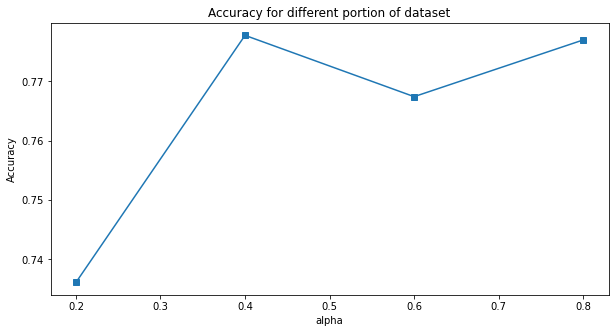

In [64]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0.0,1.0,0.2),test_accuracy,'s-')

plt.title('Accuracy for different portion of dataset')
plt.xlabel("alpha")
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

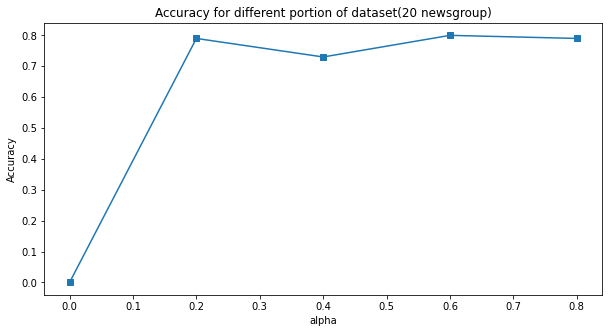

In [14]:

plt.figure(figsize=(10,5))
plt.plot(np.arange(0.0,1.0,0.2),test_accuracy,'s-')

plt.title('Accuracy for different portion of dataset(20 newsgroup)')
plt.xlabel("alpha")
plt.ylabel('Accuracy')

# cross_validation

C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in 

validation accuracy [[0.65986117 0.66761944 0.66231115 0.64434463 0.65741119]
 [0.6725194  0.6876276  0.67578604 0.67374439 0.6835443 ]
 [0.6480196  0.65822785 0.64842793 0.64189465 0.66271948]
 [0.60881993 0.61698653 0.61167824 0.6124949  0.62719477]
 [0.58472846 0.58554512 0.58758677 0.57778685 0.60187832]
 [0.56431196 0.57002858 0.57452021 0.56022866 0.58064516]
 [0.5524704  0.55492038 0.56186198 0.54593712 0.56431196]]
[0.65830951 0.67864434 0.6518579  0.61543487 0.5875051  0.56994692
 0.55590037]


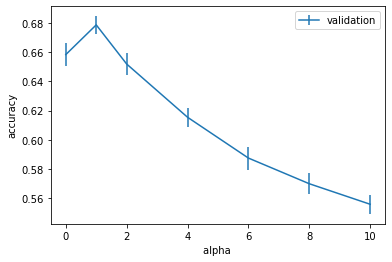

In [68]:
#new cross validation for the 20news dataset(Multinomial Naive Bayes)




###############cross validation part######################################

import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
twentynews_x = fetch_20newsgroups(subset='all',remove=(['headers','footers','quotes']))
count_vect = CountVectorizer(analyzer ='word',lowercase=True,stop_words='english',min_df=2,max_df=0.9,max_features=50000)
X_counts=count_vect.fit_transform(twentynews_x.data)



#print(features_names)
#tfidf_transformer = TfidfTransformer()
#X= tfidf_transformer.fit_transform(X_counts)
Y=twentynews_x.target
x_train, x_test, y_train, y_test = train_test_split(X_counts, Y, test_size=0.35, random_state=4)



n_folds = 5
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds
               


alphaa_list =[0,1,2,4,6,8,10]


acc_valid = np.zeros((len(alphaa_list), n_folds))
for i, alpha in enumerate(alphaa_list):
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], n_folds=5)):
        gnb = MultinomialNB(alpha)
 #       xx_train=x_train.toarray()
        y_pred = gnb.fit(x_train[tr,:], y_train[tr]).predict(x_train[val,:])
        acc_valid[i,f] = np.sum(y_pred == y_train[val])/y_pred.shape[0]              
print("validation accuracy",acc_valid)

total_accurcy=np.mean(acc_valid,axis=1) 
print(total_accurcy)  


plt.figure(figsize=(10,5))
plt.errorbar(alphaa_list, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('alpha ')
plt.ylabel('accuracy')
plt.show()
                         

In [12]:
##cross validation for the first dataset-logestic regression




import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
twentynews_x = fetch_20newsgroups(subset='all',remove=(['headers','footers','quotes']))
count_vect = CountVectorizer(analyzer ='word',lowercase=True,stop_words='english',min_df=2,max_df=0.9,max_features=50000)
X_counts=count_vect.fit_transform(twentynews_x.data)



#print(features_names)
#tfidf_transformer = TfidfTransformer()
#X= tfidf_transformer.fit_transform(X_counts)
Y=twentynews_x.target
x_train, x_test, y_train, y_test = train_test_split(X_counts, Y, test_size=0.35, random_state=4)



n_folds = 5
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds
               


max_iter =[50,400,600,800]


score = np.zeros((len(max_iter), n_folds))
for i, m in enumerate(max_iter):
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], n_folds=5)):
        
        logisticRegr = LogisticRegression(penalty="none",solver="saga",multi_class="multinomial",max_iter=m)
 #       xx_train=x_train.toarray()
        logisticRegr.fit(x_train[tr,:], y_train[tr])
        predictions = logisticRegr.predict(x_train[val,:])
        score[i,f] = logisticRegr.score(x_train[val,:], y_train[val])             
print(score)

total_score=np.mean(score,axis=1) 
print(total_score) 
                         

C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached 

[[0.36994692 0.34953042 0.39648836 0.34871376 0.37893018]
 [0.38178849 0.36096366 0.41077991 0.36463863 0.3956717 ]
 [0.39444671 0.3683136  0.41690486 0.37443855 0.4079216 ]
 [0.40628828 0.37893018 0.42792977 0.38260514 0.41894651]]
[0.36872193 0.38276848 0.39240506 0.40293998]


C:\Users\FATEMEH\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


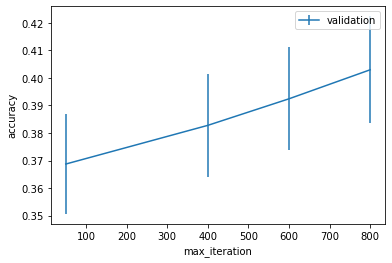

In [13]:

plt.errorbar(max_iter, np.mean(score , axis=1), np.std(score, axis=1), label='validation')
plt.legend()
plt.xlabel('max_iteration')
plt.ylabel('accuracy')
plt.show()

In [34]:
##cross validation for the first dataset-logestic regression


import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


headerss=['polarity',' id','date','query','user','review']
senti_trainn=pd.read_csv('Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv',header=None,names=headerss)
senti_test=pd.read_csv('Downloads/new_testdata.manual.2009.06.14.csv',header=None,names=headerss)
    
    
frames = [senti_trainn,senti_test]

result = pd.concat(frames)
result=result.reindex()
X=result.iloc[:,5]
Y=result.iloc[:,0]

count_vect = CountVectorizer(analyzer ='word',lowercase=True,stop_words='english',min_df=2,max_df=0.9)
X_counts=count_vect.fit_transform(X)
# tfidf_transformer = TfidfTransformer()
# X= tfidf_transformer.fit_transform(X_counts)

x_train, x_test, y_train, y_test = train_test_split(X_counts, Y, test_size=0.25, random_state=4)

# x_train=np.array(x_train)
# y_train=np.array(y_train)
n_folds = 5
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds
               


max_iter =[50,400,800]




score = np.zeros((len(max_iter), n_folds))
for i, m in enumerate(max_iter):
    for f, (tr, val) in enumerate(cross_validate(1200108, n_folds=5)):
        
        logisticRegr = LogisticRegression(penalty="12",solver="saga",multi_class="multinomial",max_iter=m)
 #       xx_train=x_train.toarray()
        logisticRegr.fit(x_train[tr,:], y_train[tr])
        predictions = logisticRegr.predict(x_train[val,:])
        score[i,f] = logisticRegr.score(x_test[val,:], y_train[val,:])             

                        

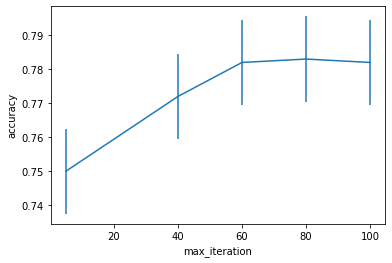

In [32]:
max_iteration =[5,40,60,80,100]
plt.errorbar(max_iteration, np.mean(Sc , axis=1), np.std(Sc, axis=0))

plt.xlabel('max_iteration')
plt.ylabel('accuracy')
plt.show()

In [33]:
#new cross validation for the 20news dataset(Multinomial Naive Bayes)




###############cross validation part######################################

import pandas as pd 
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


n_folds = 5
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds
               


alphaa_list =[0,1,2,4,6,8,10]


acc_valid = np.zeros((len(alphaa_list), n_folds))
for i, alpha in enumerate(alphaa_list):
    for f, (tr, val) in enumerate(cross_validate(1200108, n_folds=5)):
        gnb = MulltinomialNB(alpha,y_train[tr])
 #       xx_train=x_train.toarray()
        y_pred = gnb.fit(x_train[tr], y_train[tr])
        gnb.predict(x_train[val,:])
        acc_valid[i,f] = np.sum(y_pred == y_train[val,:])/y_pred.shape[0]              
print("validation accuracy",acc_valid)

total_accurcy=np.mean(acc_valid,axis=1) 
print(total_accurcy)  


plt.figure(figsize=(10,5))
plt.errorbar(alphaa_list, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('alpha ')
plt.ylabel('accuracy')
plt.show()
                         